In [2]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Attribute Information:
STG: The degree of study time for goal object materails.
SCG: The degree of repetition number of user for goal object materails.
STR: The degree of study time of user for related objects with goal object.
LPR: The exam performance of user for related objects with goal object.
PEG: The exam performance of user for goal objects.
UNS: The knowledge level of user.

In [3]:
# load data in and convert <chr> to <fct> for categorical variable UNS
user_training <- read_csv("User Knowledge Training Set.csv")
user_training[user_training == "very_low"] <- "Very Low"
user_training <- mutate(user_training, UNS = as_factor(UNS))
head(user_training)

user_testing <- read_csv("User Knowledge Testing Set.csv")
user_testing <- mutate(user_testing, UNS = as_factor(UNS))
head(user_testing)

Parsed with column specification:
cols(
  STG = col_double(),
  SCG = col_double(),
  STR = col_double(),
  LPR = col_double(),
  PEG = col_double(),
  UNS = col_character()
)



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


Parsed with column specification:
cols(
  STG = col_double(),
  SCG = col_double(),
  STR = col_double(),
  LPR = col_double(),
  PEG = col_double(),
  UNS = col_character()
)



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


In [4]:
# mean of all the observations from STG to PEG
overall_mean <- user_training %>% 
                select(STG:PEG) %>% 
                map_dfr(mean)
overall_mean

num_of_observations <- nrow(user_training)
num_of_observations

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3711473,0.3556744,0.4680039,0.4327132,0.4585388


[1] 258

In [5]:
# mean of observations which has "Very Low" UNS from STG to PEG
user_training_very_low <- user_training %>% 
                          filter(UNS == "Very Low")
very_low_mean <- user_training_very_low %>% 
                 select(STG:PEG) %>% 
                 map_dfr(mean)
very_low_mean

num_of_very_low <- nrow(user_training_very_low)
num_of_very_low

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3057917,0.198125,0.36625,0.35875,0.09083333


[1] 24

In [6]:
# mean of observations which has "Low" UNS from STG to PEG
user_training_low <- user_training %>% 
                     filter(UNS == "Low")
low_mean <- user_training_low %>% 
            select(STG:PEG) %>% 
            map_dfr(mean)
low_mean

num_of_low <- nrow(user_training_low)
num_of_low

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3211446,0.337,0.4307229,0.4973494,0.2376265


[1] 83

In [7]:
# mean of observations which has "Middle" UNS from STG to PEG
user_training_middle <- user_training %>% 
                        filter(UNS == "Middle")
middle_mean <- user_training_middle %>% 
               select(STG:PEG) %>% 
               map_dfr(mean)
middle_mean

num_of_middle <- nrow(user_training_middle)
num_of_middle

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3999773,0.3679205,0.5068182,0.3428409,0.5423864


[1] 88

In [8]:
# mean of observations which has "High" UNS from STG to PEG
user_training_high <- user_training %>% 
                      filter(UNS == "High")
high_mean <- user_training_high %>% 
             select(STG:PEG) %>% 
             map_dfr(mean)
high_mean

num_of_high <- nrow(user_training_high)
num_of_high

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.4216508,0.4231905,0.5016667,0.5012698,0.7725397


[1] 63

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



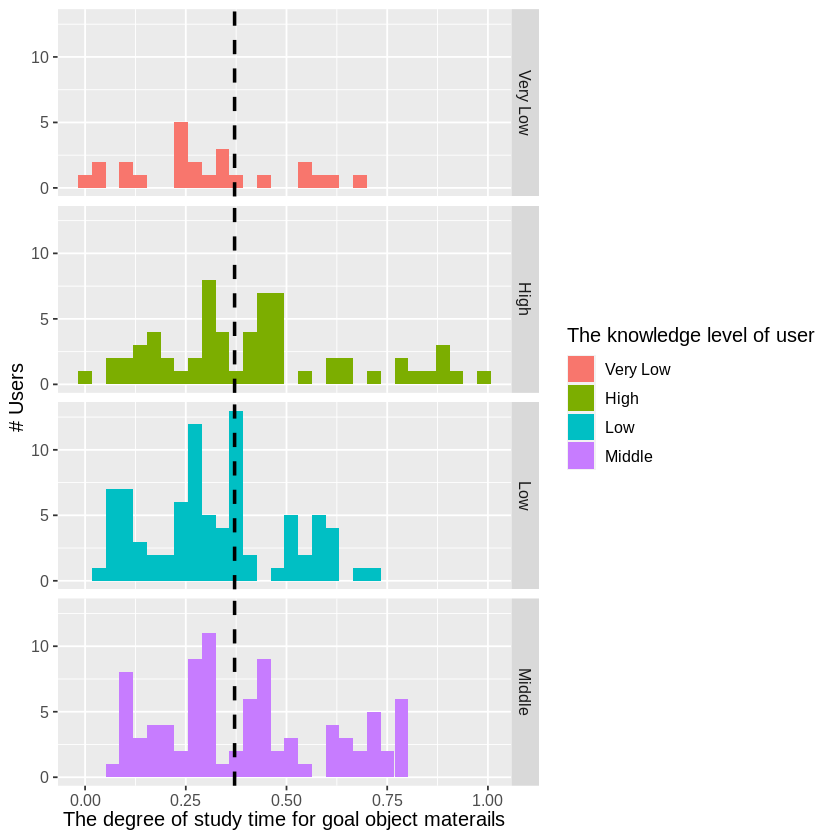

In [26]:
# For users with different knowledge level, plot the distribution of each category's degree of study time 
# for goal object materails (STG), with the overall mean of STG.
STG_plot <- user_training %>%
    select(STG,UNS) %>%
    ggplot(aes(x = STG, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.3711473, linetype = "dashed", size = 1.0) +
    labs(x = "The degree of study time for goal object materails", y = "# Users", fill = "The knowledge level of user") +
    theme(text = element_text(size = 12))
STG_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



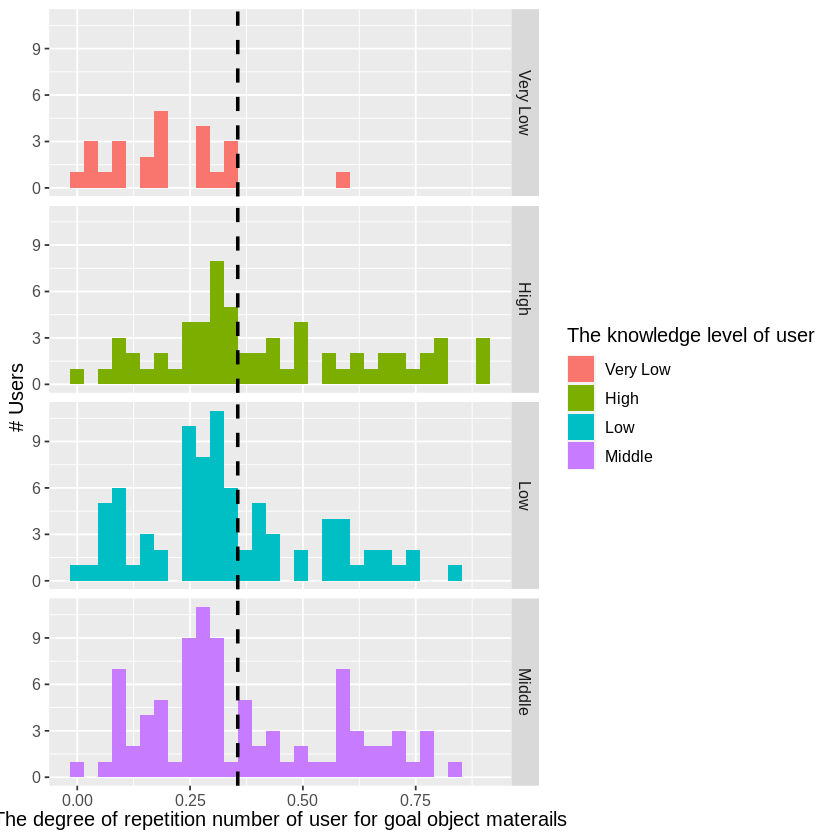

In [27]:
# For users with different knowledge level, plot the distribution of each category's degree of 
# repetition number of user for goal object materails (SCG), with the overall mean of SCG.
SCG_plot <- user_training %>%
    select(SCG,UNS) %>%
    ggplot(aes(x = SCG, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.3556744, linetype = "dashed", size = 1.0) +
    labs(x = "The degree of repetition number of user for goal object materails", y = "# Users", fill = "The knowledge level of user") +
    theme(text = element_text(size = 12))
SCG_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



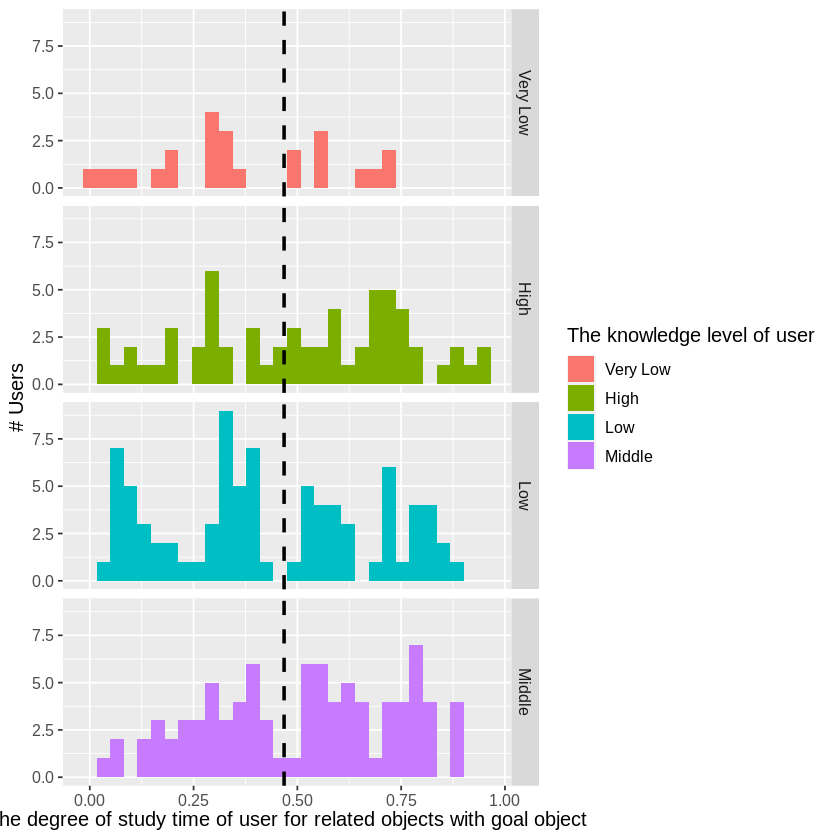

In [28]:
# For users with different knowledge level, plot the distribution of each category's degree of 
# study time of user for related objects with goal object (STR), with the overall mean of STR.
STR_plot <- user_training %>%
    select(STR,UNS) %>%
    ggplot(aes(x = STR, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.4680039, linetype = "dashed", size = 1.0) +
    labs(x = "The degree of study time of user for related objects with goal object", y = "# Users", fill = "The knowledge level of user") +
    theme(text = element_text(size = 12))
STR_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



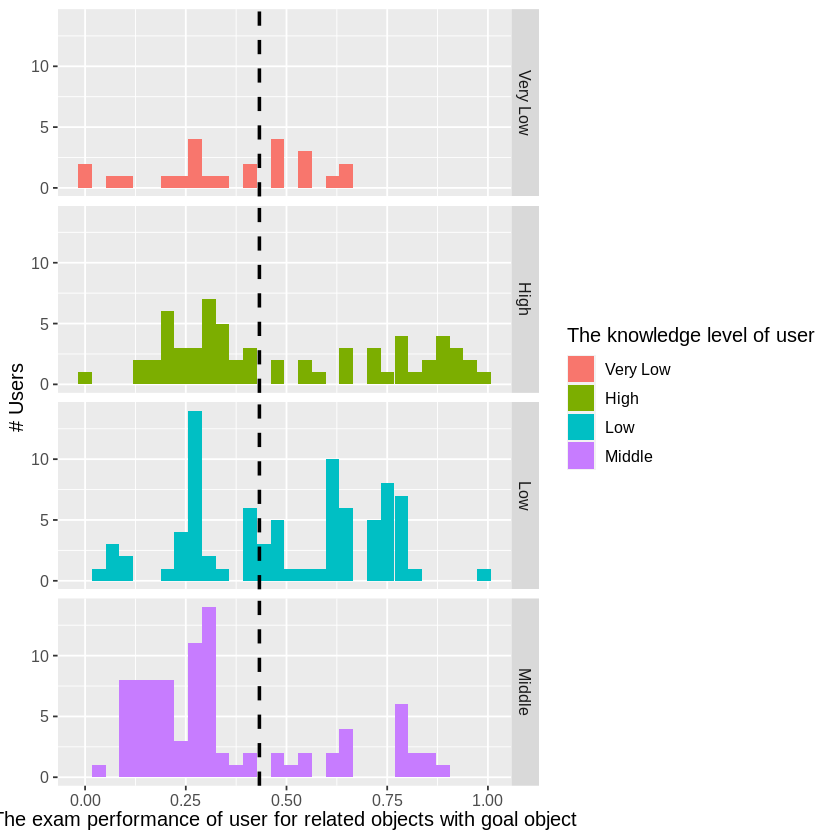

In [30]:
# For users with different knowledge level, plot the distribution of each category's performance
# for related objects with goal object (LPR), with the overall mean of lPR.
LPR_plot <- user_training %>%
    select(LPR,UNS) %>%
    ggplot(aes(x = LPR, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.4327132, linetype = "dashed", size = 1.0) +
    labs(x = "The exam performance of user for related objects with goal object", y = "# Users", fill = "The knowledge level of user") +
    theme(text = element_text(size = 12))
LPR_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



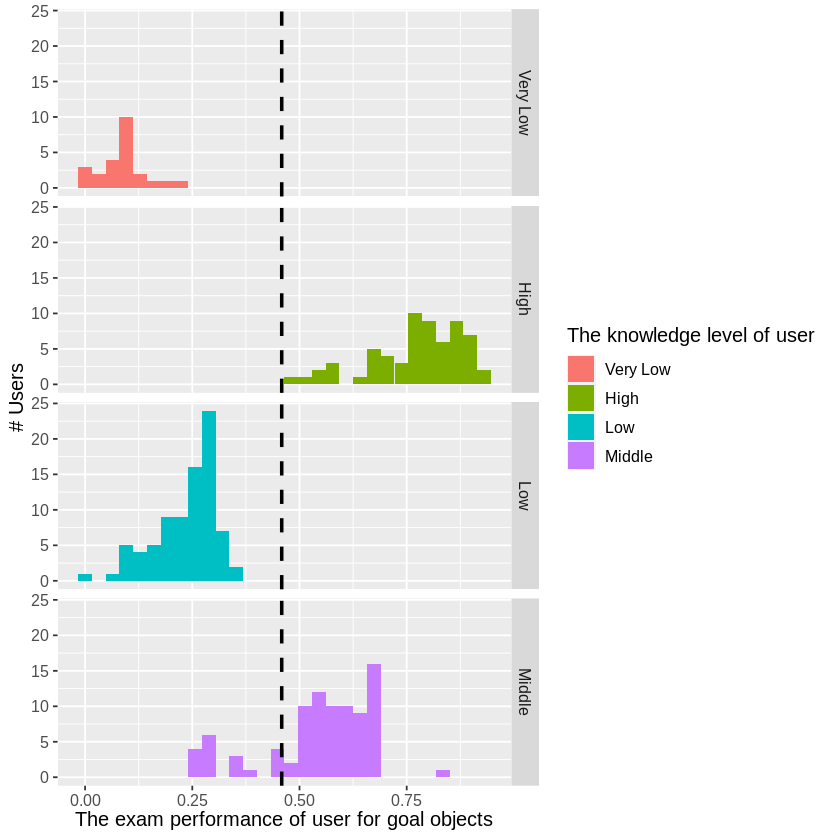

In [31]:
# For users with different knowledge level, plot the distribution of each category's exam performance 
# for goal objects(PEG), with the overall mean of PEG.
PEG_plot <- user_training %>%
    select(PEG,UNS) %>%
    ggplot(aes(x = PEG, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.4585388, linetype = "dashed", size = 1.0) +
    labs(x = "The exam performance of user for goal objects", y = "# Users", fill = "The knowledge level of user") +
    theme(text = element_text(size = 12))
PEG_plot

From the plots generated above, it can be observed that, for STG, SCG, STR, and LPR, the distributions of the 4 levels of users do not vary widely. However, the distributions clearly differ when it comes to PEG. This suggests that PEG can be a very important variable for predicting user's knowledge level.